In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import random
import sklearn
import collections
from sklearn.model_selection import train_test_split
import json
import pylab
from scipy.optimize import curve_fit
from tensorflow.keras import layers, Model
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc
import sklearn.metrics as sk

2024-02-06 20:12:35.112037: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-06 20:12:35.605310: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def create_AE(input_dim, h_dim_1, h_dim_2, latent_dim):
    # Encoder
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(h_dim_1, activation='relu')(inputs)
    x = layers.Dense(h_dim_2, activation='relu')(x)
    z = layers.Dense(latent_dim, activation='relu')(x)

    # Decoder
    x = layers.Dense(h_dim_2, activation='relu')(z)
    x = layers.Dense(h_dim_1, activation='relu')(x)
    outputs = layers.Dense(input_dim)(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

def loss_fn(y_true, y_pred):
    """masked mse"""
    mask = K.cast(K.not_equal(y_true, 0), K.floatx())
    squared_difference = K.square(mask * (y_pred - y_true))
    return K.mean(squared_difference)

def mse_loss(true, prediction):
    loss = np.mean(np.square(true - prediction), axis=-1)
    return loss

def AD_score(y, x):
    # masked mse
    mask = (y != 0)
    _x = x * mask
    _y = y * mask
    return (mse_loss(_y, _x))


class Model_Evaluator():
  def __init__(self,model_path,backround,signal,title='placeholder',save=False,labels=None):
    custom_objects = {'loss_fn': loss_fn}
    self.model = load_model(model_path, custom_objects=custom_objects)
    self.signal=signal
    self.backround=backround
    self.br_loss=[]
    self.signal_loss=[]
    self.backround_outputs=[]
    self.signal_outputs=[]
    self.title=title
    self.saveplots=save
    self.labels=labels

  def calculate_loss(self,batch_size):

    br=self.backround
    self.backround_outputs=self.model.predict(br)
    self.br_loss=AD_score(self.backround,self.backround_outputs)
    for i, batch in enumerate(self.signal):
      sr=batch
      self.signal_outputs+=[self.model.predict(sr)]
      self.signal_loss+=[AD_score(batch,self.signal_outputs[i])]
    return [self.br_loss,self.signal_loss]


  def histogram(self,bins):
    plt.hist(self.br_loss,bins=bins,histtype='step',label='backround num_events:{}'.format(len(self.br_loss)))
    for i,batch in enumerate(self.signal_loss):
      plt.hist(batch,bins=bins,histtype='step',label=str(self.labels[i+1])+" num_events:{}".format(len(batch)))
    plt.xlabel('loss')
    plt.ylabel('Frequency')
    plt.yscale('log')
    plt.title("{}_Hist".format(self.title))
    plt.legend()
    if self.saveplots==True:
      plt.savefig("/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/analyses_plots/{}_Hist.png".format(self.title), format="png", bbox_inches="tight")
    plt.show()

  def ROC(self):
    plt.plot(np.linspace(0,1,1000),np.linspace(0,1,1000),'--',label='diagonal')
    for j, batch in enumerate(self.signal_loss):
      truth=[]
      for i in range(len(self.br_loss)):
        truth+=[0]
      for i in range(len(batch)):
        truth+=[1]
      ROC_data=np.concatenate((self.br_loss,batch))
      fpr,tpr,x=sk.roc_curve(truth,ROC_data)
    #auc=np.trapz(tpr,fpr)
      auc=sk.roc_auc_score(truth,ROC_data)
      plt.plot(fpr,tpr,label=self.labels[j+1]+": "+str(auc))

    plt.xlabel('fpr')
    plt.semilogx()
    plt.ylabel('trp')
    plt.semilogy()
    plt.title("{}_ROC".format(self.title))
    plt.legend()
    if self.saveplots==True:
      plt.savefig("/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/analyses_plots/{}_ROC.png".format(self.title), format="png", bbox_inches="tight")
    plt.show()
  
  def Find_AD_Cutoff(self,br_rate,desired_rate,starting_AD):
    N=self.backround.shape[0]
    AD_max=starting_AD
    AD_List=np.linspace(0,AD_max,num=1000)
    best_AD=0
    for i,AD in enumerate(np.flip(AD_List)):
      n=0
      for loss in self.br_loss:
        if loss>=AD:
          n+=1
      sigrate=br_rate*n/N
      if sigrate<=desired_rate:
        best_AD=AD
      if sigrate>desired_rate:
        break
    self.AD_cutoff=best_AD
    return best_AD
    
  def calculate_sensitivity(self,br_rate):
    AD=self.AD_cutoff
    sensitivity=[]
    for i,losses in enumerate(self.signal_loss):
        N=len(losses)
        n=0
        for loss in losses:
            if loss>=AD:
                n+=1
        sen=n/N
        sensitivity+=[sen]
    self.signal_sensitivity=sensitivity
    print(self.signal_sensitivity)
        
    
        





In [3]:
f=h5py.File('/eos/home-w/wsherman/AD_Work/n_tuples/40MHZ_data/background_for_training.h5','r')
Dataset=np.array(f["Particles"])

truthtable=[]

threshold=50
for i, batch in enumerate(Dataset):
  if np.sum(batch[:,0])>=threshold:
    truthtable+=[1]
  else:
    truthtable+=[0]

event_pt_br=[]
Data_Test_full=Dataset[2000001:3600000,:,:]
for j, br_1 in enumerate(Data_Test_full):
  event_pt_br+=[np.sum(br_1[:,0])]

for i, batch in enumerate(Dataset):
  pt_sum=0
  for j, particle in enumerate(Dataset[i,:,:]):
    if particle[3]!=0:
      pt_sum+=particle[0]
  for j, particle in enumerate(Dataset[i,:,:]):
    particle[0]=particle[0]/pt_sum

Data_Train=Dataset[0:2000000,:,0:3]
Data_Test=Dataset[2000001:3600000,:,0:3]
Test_Truth=truthtable[2000001:3600000]
Data_Validate=Dataset[3600001:4000000,:,0:3]

Data_Test_Flat=np.reshape(Data_Test,(-1,57))

In [4]:



h_to_Tau_Tau=h5py.File('/eos/home-w/wsherman/AD_Work/n_tuples/40MHZ_data/hToTauTau_13TeV_PU20.h5','r')
A_to_4_l=h5py.File('/eos/home-w/wsherman/AD_Work/n_tuples/40MHZ_data/Ato4l_lepFilter_13TeV.h5','r')
hC_to_Tau_Nu=h5py.File('/eos/home-w/wsherman/AD_Work/n_tuples/40MHZ_data/hChToTauNu_13TeV_PU20.h5','r')
lepto=h5py.File('/eos/home-w/wsherman/AD_Work/n_tuples/40MHZ_data/leptoquark_LOWMASS_lepFilter_13TeV.h5','r')

h_tt_set=np.array(h_to_Tau_Tau["Particles"])
hC_tn_set=np.array(hC_to_Tau_Nu["Particles"])
A_4l_set=np.array(A_to_4_l["Particles"])
lepto_set=np.array(lepto["Particles"])
sets=[h_tt_set,hC_tn_set,A_4l_set,lepto_set]
#sets=[lepto_set]

#sets2=[hC_tn_set,h_tt_set,A_4l_set,lepto_set]
#signal_pt=[[],[],[],[]]
#for i, signal in enumerate(sets2):
#  for j in range(0,len(signal)):
#    event_pT=np.sum(signal[j,:,0])
#    signal_pt[i]+=[event_pT]






for k, subset in enumerate(sets):
  for i, batch in enumerate(subset):
    pt_sum=0
    for j, particle in enumerate(subset[i,:,:]):
      if particle[3]!=0:
        pt_sum+=particle[0]
    for j, particle in enumerate(subset[i,:,:]):
      particle[0]=particle[0]/pt_sum
  print('one set done')

normed_signals=[]
for j, subset in enumerate(sets):
    normed_signals+=[np.reshape(subset[:,:,0:3],(-1,57))]

#pt_all=[]
#pt_met=[]
#multiplicity=[]
#eta_average=[]
#signals=sets
#for i, signal in enumerate(signals):
#  for j in range(0,len(signal)):
#    multi=0
#    event_pT=np.sum(signal[j,:,0])
#    event_eta=np.average(signal[j,:,1])
#    eta_average+=[event_eta]
#    pt_all+=[event_pT]
#    for k in range(0,19):
#      if signal[j,k,3]==1:
#        pt_met+=[signal[j,k,0]]
#   #   if signal[j,k,3]!=0:
  #      multi+=1
 #   multiplicity+=[multi]

#hC_tn_data=np.reshape(sets[1][:,:,0:3],(-1,57))
#h_tt_data=np.reshape(sets[0][:,:,0:3],(-1,57))
#Test_Reshaped=np.reshape(Data_Test,(-1,57))
#A_4l=np.reshape(sets[2][:,:,0:3],(-1,57))
#lepto_data=np.reshape(sets[3][:,:,0:3],(-1,57))

sig_label=['Backround','hC_tn','h_tt','A_4l','leptoquark']

one set done
one set done
one set done
one set done


In [5]:
hf=h5py.File('/eos/home-w/wsherman/AD_Work/n_tuples/40MHZ_data/H_tt_data_for_model.h5','w')
hf.create_dataset('dataset',data=normed_signals[0])
hf.close()

custom_objects1 = {'loss_fn': loss_fn}
model1 = load_model('/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/trained_models/40MHZ_norm_DNN.keras', custom_objects=custom_objects1)
model1.save_weights('/eos/home-w/wsherman/AD_Work/n_tuples/40MHZ_data/AE_model_weights.h5',save_format='h5')
model1.save('/eos/home-w/wsherman/AD_Work/n_tuples/40MHZ_data/AE_model.h5')

/cvmfs/sft.cern.ch/lcg/views/LCG_105_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10642/10642 [==============================] - 16s 1ms/step


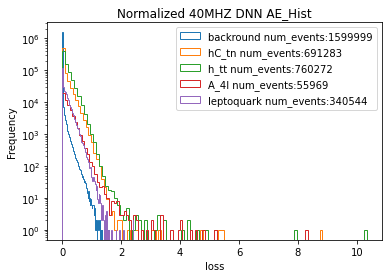

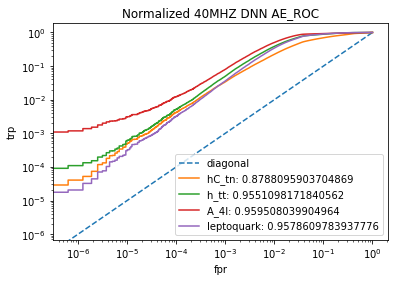

In [6]:
evaluation=Model_Evaluator('/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/trained_models/40MHZ_norm_DNN.keras',Data_Test_Flat,normed_signals,title='Normalized 40MHZ DNN AE', save=True,labels=sig_label)
evaluation.calculate_loss(1024)
evaluation.histogram(bins=100)
evaluation.ROC()


In [7]:
#evaluation.Find_AD_Cutoff(40*10**6,10,10)


In [8]:
#evaluation.calculate_sensitivity(40*10**6)